# SAEval

In [24]:
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

## Sufficency / Necessity

In [25]:
dfs = [] 
for file in os.listdir('tasks/ioi/sn-scores/'):
    if file.endswith('.json'):
        file_name = file.split('.')[0]
        data = pd.read_json('tasks/ioi/sn-scores/' + file)
        data['node'] = file_name
        dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

In [26]:
sufficency_df = df[['node', 'clean_ld', 'supervised_full_ld', 'sae_full_ld']].copy()
necessity_df = df[['node', 'clean_ld', 'supervised_average_ld', 'sae_average_ld', 'ablation_ld']].copy()

In [27]:
sufficency_df['supervised_diff'] = sufficency_df['clean_ld'] - sufficency_df['supervised_full_ld']
sufficency_df['sae_diff'] = sufficency_df['clean_ld'] - sufficency_df['sae_full_ld']

sufficency_df = sufficency_df.groupby('node').mean()

In [28]:
sufficency_df['supervised_score'] = sufficency_df['supervised_diff'] / sufficency_df['clean_ld']
sufficency_df['sae_score'] = sufficency_df['sae_diff'] / sufficency_df['clean_ld']

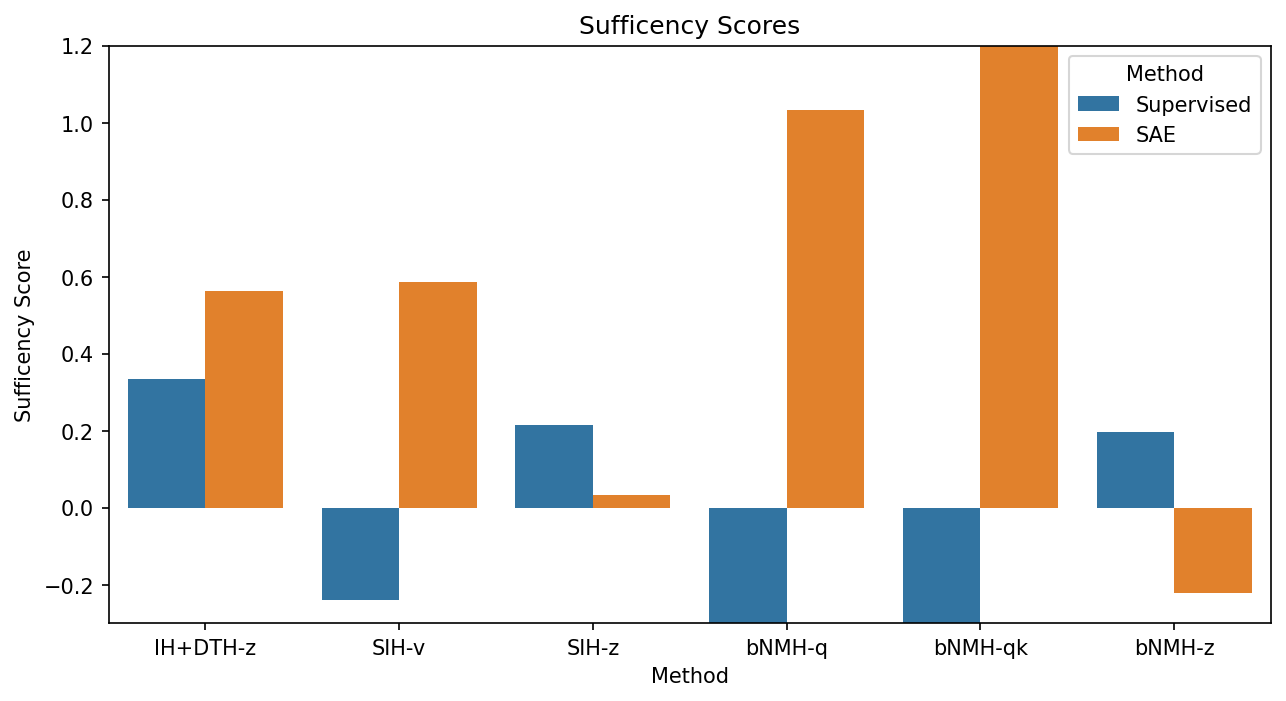

In [29]:
scores = sufficency_df[['supervised_score', 'sae_score']].reset_index()
scores.columns = ['Node', 'Supervised', 'SAE']

plt.figure(figsize=(10, 5), dpi=150)
ax = sns.barplot(data=scores.melt(id_vars='Node', var_name='Method', value_name='Sufficency Score'), x='Node', y='Sufficency Score', hue='Method')
ax.set(xlabel='Method', ylabel='Sufficency Score')
plt.ylim(-.3, 1.2)
plt.title('Sufficency Scores')
plt.show()

In [41]:
necessity_df['supervised_diff'] = (necessity_df['ablation_ld'] - necessity_df['supervised_average_ld']).abs()
necessity_df['sae_diff'] = (necessity_df['ablation_ld'] - necessity_df['sae_average_ld']).abs()
necessity_df['ablation_diff'] = (necessity_df['ablation_ld'] - necessity_df['clean_ld']).abs()

#necessity_df['supervised_score'] = necessity_df['supervised_diff'] / necessity_df['ablation_diff']
#necessity_df['sae_score'] = necessity_df['sae_diff'] / necessity_df['ablation_diff']

necessity_df = necessity_df.groupby('node').mean()

In [42]:
necessity_df['supervised_score'] = necessity_df['supervised_diff'] / necessity_df['ablation_diff']
necessity_df['sae_score'] = necessity_df['sae_diff'] / necessity_df['ablation_diff']

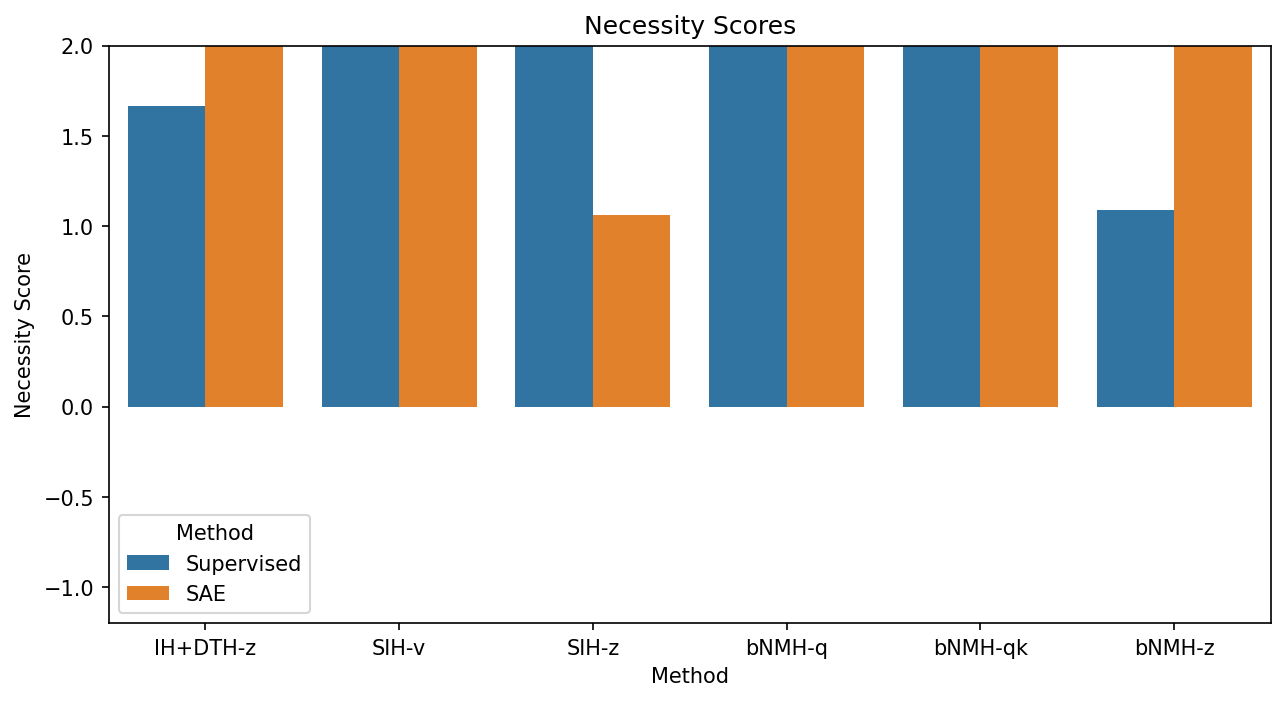

In [43]:
scores = necessity_df[['supervised_score', 'sae_score']].reset_index()
scores.columns = ['Node', 'Supervised', 'SAE']

plt.figure(figsize=(10, 5), dpi=150)
ax = sns.barplot(data=scores.melt(id_vars='Node', var_name='Method', value_name='Sufficency Score'), x='Node', y='Sufficency Score', hue='Method')
ax.set(xlabel='Method', ylabel='Necessity Score')
plt.ylim(-1.2, 2)
plt.title('Necessity Scores')
plt.show()

## Sparse Controllability

In [179]:
dfs = [] 
for file in os.listdir('tasks/ioi/sc-scores/'):
    if file.endswith('.json'):
        file_name = file.split('.')[0]
        data = pd.read_json('tasks/ioi/sc-scores/' + file)
        data['node'] = file_name
        dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

/var/folders/nz/t1t1ksr15lz7qypv0qvd5zyr0000gn/T/ipykernel_5063/2105426135.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  ax = sns.barplot(data=plot_df, x='Node', y='Score', hue='Method', errwidth=0.5)


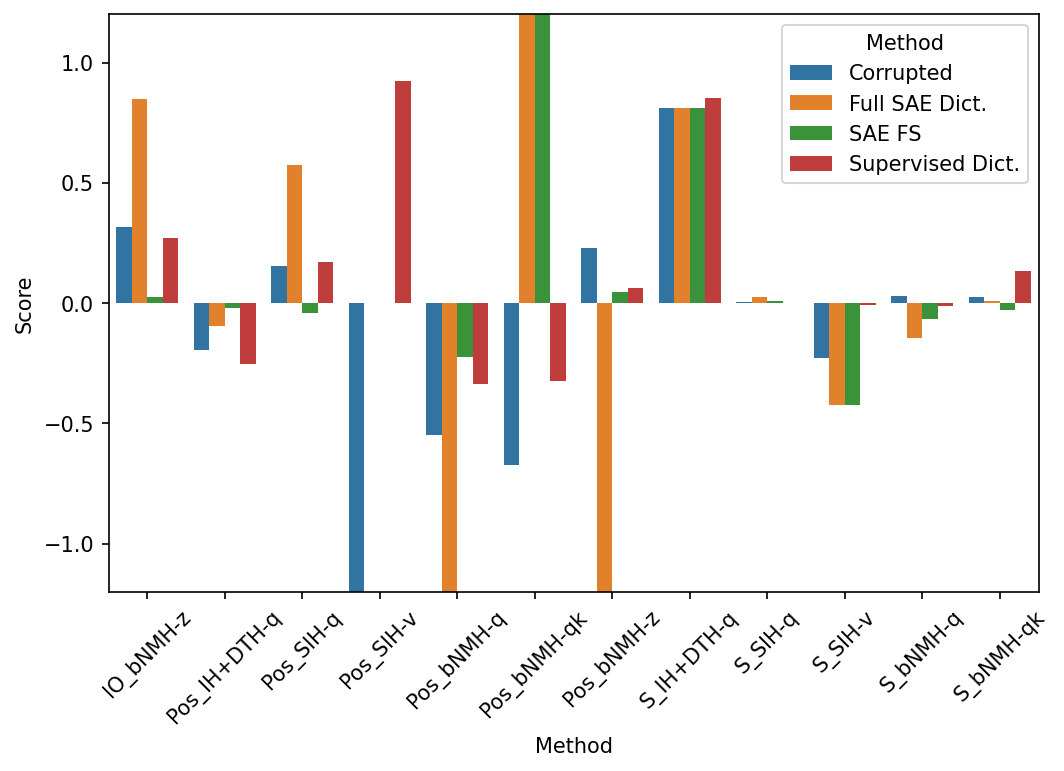

In [180]:
scores = df[['patch_corr_score', 'patch_supervised_score', 'patch_all_sae_score', 'patch_sae_fs_score', 'node']]
scores.columns = ['Corrupted', 'Supervised Dict.', 'Full SAE Dict.', 'SAE FS', 'Node']

plt.figure(figsize=(8, 5), dpi=150)
plot_df = scores.melt(id_vars='Node', var_name='Method', value_name='Score').groupby(['Node', 'Method']).mean().reset_index()
ax = sns.barplot(data=plot_df, x='Node', y='Score', hue='Method', errwidth=0.5)
ax.set_ylabel('Score')
ax.set_xlabel('Method')
plt.ylim(-1.2, 1.2)
plt.xticks(rotation=45)
plt.show()

In [231]:

# Create ldiff DataFrame
ldiff = df[['corr_ld', 'patch_corr_ld',  'patch_all_sae_ld', 'patch_sae_fs_ld', 'patch_supervised_ld', 'node']]
ldiff.columns = ['Corrupted Run', 'Patch Corrupted', 'Full SAE Dict.', 'Patch SAE FS', 'Patch Supervised Dict.', 'Node']

# Create data_subset DataFrame
data_subset = df[['clean_ld', 'node']]
data_subset.columns = ['Clean Run','Node']
print(data_subset)

# Group by Node
grouped = ldiff.groupby('Node')
data_subset_grouped = data_subset.groupby('Node')

# store results
results = {}

for node, group in grouped:
    print(f"node {node}")
    data_subset_group = data_subset_grouped.get_group(node)
    
    # Create mask for positive clean_ld values
    mask = data_subset_group['Clean Run'] > 0
    
    # Calculate threshold
    threshold = 0.05 * data_subset_group['Clean Run']
    print(threshold)
    
    # Compare each column with baseline
    for col in group.columns:
        if col != 'Node':
            agreement = (abs(group.loc[mask, col] - data_subset_group.loc[mask, 'Clean Run']) <= threshold)
            
            # Store results
            if node not in results:
                results[node] = {}
            results[node][col] = agreement.mean()

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T

print(results_df)

      Clean Run       Node
0      9.196618  IO_bNMH-z
1      8.146939  IO_bNMH-z
2      8.631424  IO_bNMH-z
3      9.004820  IO_bNMH-z
4      8.263018  IO_bNMH-z
...         ...        ...
6139   2.964078  Pos_SIH-q
6140   2.522445  Pos_SIH-q
6141   5.106237  Pos_SIH-q
6142   3.429747  Pos_SIH-q
6143   1.996371  Pos_SIH-q

[6144 rows x 2 columns]
node IO_bNMH-z
0      0.459831
1      0.407347
2      0.431571
3      0.450241
4      0.413151
         ...   
507    0.450853
508    0.322964
509    0.300397
510    0.435267
511    0.300499
Name: Clean Run, Length: 512, dtype: float64
node Pos_IH+DTH-q
4096    0.123935
4097    0.138228
4098    0.261953
4099    0.119258
4100    0.228771
          ...   
4603    0.148204
4604    0.126122
4605    0.255312
4606    0.171487
4607    0.099819
Name: Clean Run, Length: 512, dtype: float64
node Pos_SIH-q
5632    0.123935
5633    0.138228
5634    0.261953
5635    0.119258
5636    0.228771
          ...   
6139    0.148204
6140    0.126122
6141    0.2553

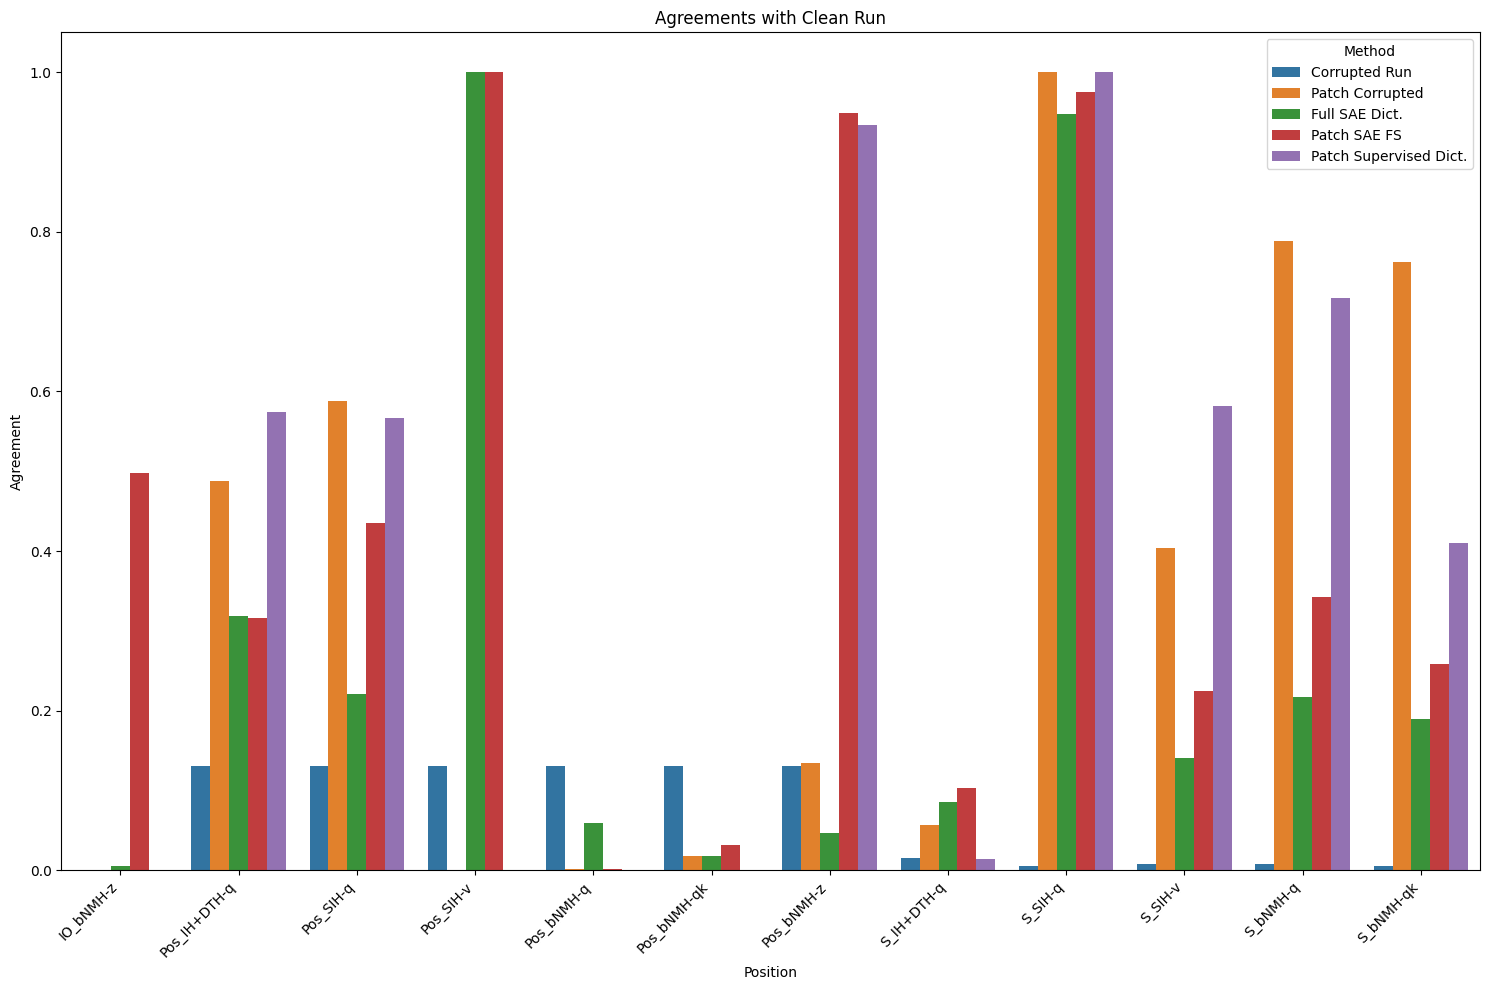

In [235]:
# Reset index to turn the index into a column
results_df_reset = results_df.reset_index()
results_df_reset = results_df_reset.rename(columns={'index': 'Position'})

# Melt the DataFrame to long format
df_melted = results_df_reset.melt(id_vars='Position', var_name='Method', value_name='Agreement')

# Create the plot
plt.figure(figsize=(15, 10))
plt.title("Agreements with Clean Run")
sns.barplot(x='Position', y='Agreement', hue='Method', data=df_melted)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Adjust the subplot layout
plt.tight_layout()

# Show the plot
plt.show()


In [234]:
# Create ldiff DataFrame
print(df)
ldiff = df[['clean_ld', 'patch_corr_ld', 'patch_all_sae_ld', 'patch_sae_fs_ld', 'patch_supervised_ld', 'node']]
ldiff.columns = ['Clean Run', 'Patch Corrupted', 'Full SAE Dict.', 'Patch SAE FS', 'Patch Supervised Dict.', 'Node']

# Create data_subset DataFrame
data_subset = df[['corr_ld', 'node']]
data_subset.columns = ['Corrupted Run','Node']

# Group by Node
grouped = ldiff.groupby('Node')
data_subset_grouped = data_subset.groupby('Node')

# store results
results = {}

for node, group in grouped:
    print(f"node {node}")
    data_subset_group = data_subset_grouped.get_group(node)
    
    # Create mask for positive clean_ld values
    mask = data_subset_group['Corrupted Run'] > 0
    
    # Calculate threshold
    threshold = 0.1 * data_subset_group['Corrupted Run']
    print(abs(threshold))
    
    # Compare each column with baseline
    for col in group.columns:
        if col != 'Node':
            agreement = (abs(group.loc[mask, col] - data_subset_group.loc[mask, 'Corrupted Run']) <= threshold)
            
            # Store results
            if node not in results:
                results[node] = {}
            results[node][col] = agreement.mean()

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T

print(results_df)

      clean_ld   corr_ld  patch_corr_ld  patch_corr_score  \
0     9.196618 -4.925656       5.521699          0.260221   
1     8.146939 -5.530145       4.574584          0.261193   
2     8.631424 -5.516353       4.202795          0.313026   
3     9.004820 -5.921615       4.615408          0.294070   
4     8.263018 -7.325390       3.888163          0.280648   
...        ...       ...            ...               ...   
6139  2.964078  3.453401       3.058450          0.192862   
6140  2.522445  4.761069       2.716519          0.086694   
6141  5.106237  4.591607       5.182491         -0.148172   
6142  3.429747  4.738379       3.874735          0.340041   
6143  1.996371  1.022360       2.199205         -0.208246   

      patch_supervised_ld  patch_supervised_score  patch_all_sae_ld  \
0                6.258638                0.208039        -11.104477   
1                4.593412                0.259816          4.038558   
2                5.186555                0.243492     

ValueError: Can only compare identically-labeled Series objects

In [ ]:
plt.figure(figsize=(10, 5), dpi=150)
sns.barplot((1-ldiff < 0).mean())
plt.title('Agreements with corrupted run')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ldiff_dist = np.array((1-ldiff["Full SAE Dict."] < 0))
indices = np.where(ldiff_dist == 0)
print(f"Agreement Histogram for Full SAE Dict {indices[0]}")

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(range(512), ldiff_dist.flatten(), width=1, edgecolor='black', linewidth=0.5)
ax.set(xlabel='Column Index', xticks=range(0, 512, 32), xticklabels=range(0, 512, 32), 
       ylabel='Binary Value', ylim=(0, 1), title='Distribution of 0\'s Across 512 Columns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
